In [20]:
# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

import xgboost as xgb  #GBM algorithm
from xgboost import XGBRegressor
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   # Perforing grid search

from IPython.display import display

# remove warnings
import warnings
warnings.filterwarnings('ignore')

In [21]:
train_data = pd.read_csv('data/new_train.csv')
test_data = pd.read_csv('data/new_test.csv')

print train_data.shape
display(train_data.head(1))
# display(train_data.info())

print test_data.shape
display(test_data.head(1))
# display(test_data.info())
train_length = train_data.shape[0]

(1460, 270)


,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LandSlope,OverallQual,OverallCond,...,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Id,SalePrice
0,0.140357,0.032874,0.693147,0.0,0.693147,0.693147,0.693147,0.693147,0.510826,0.405465,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,12.247699


(1459, 269)


,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LandSlope,OverallQual,OverallCond,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Id
0,0.184032,0.047118,0.693147,0.0,0.693147,0.693147,0.693147,0.693147,0.367725,0.485508,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1461


In [22]:
def float_range(start,stop,nums):
    ''' Computes a range of floating value.
        
        Input:
            start (float)  : Start value.
            end   (float)  : End value
            nums (integer): Number of values
        
        Output:
            A list of floats
    '''
    return [start+float(i)*(stop-start)/(float(nums)-1) for i in range(nums)]

In [23]:
train_id = train_data['Id']
train_Y = train_data['SalePrice']
train_data.drop(['Id', 'SalePrice'], axis=1, inplace=True)
train_X = train_data

test_id = test_data['Id']
test_data.drop('Id', axis=1, inplace=True)
test_X = test_data

In [24]:
# formatting for xgb
dtrain = xgb.DMatrix(train_X, label=train_Y)
dtest = xgb.DMatrix(test_X)

# XGBoost  & Parameter Tuning

Ref: [Complete Guide to Parameter Tuning in XGBoost](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)

## Parameters Tuning Plan

The overall parameters can be divided into 3 categories:

1. General Parameters: Guide the overall functioning
2. Booster Parameters: Guide the individual booster (tree/regression) at each step
3. Learning Task Parameters: Guide the optimization performed

In `XGBRegressor`:
```
class xgboost.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='reg:linear', nthread=-1, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, seed=0, missing=None)
```

In [17]:
# set initial parameters
xgb_regressor = XGBRegressor(
                learning_rate =0.1,
                n_estimators=50,
                max_depth=5,
                min_child_weight=1,
                gamma=0,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_lambda = 0.1,
                reg_alpha = 0.1,
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

xgb_param = xgb_regressor.get_xgb_params()

In [81]:
def model_cross_validate(xgb_regressor, cv_paramters, dtrain, 
              cv_folds = 5, early_stopping_rounds = 50, perform_progress=False):
    """
    xgb model cross validate to choose best param from giving cv_paramters.
    
    @param cv_paramters:dict,where to choose best param. {'param':[1,2,3]}
    @param dtrain:xgboost.DMatrix, training data formatted for xgb
    @param early_stopping_rounds: Activates early stopping.Stop when perfomance 
                                  does not improve for some rounds
    """
    # get initial parameters
    xgb_param = xgb_regressor.get_xgb_params()
    
    # save best param
    best_param = {}
    best_cvresult = None
    min_mean_rmse = float("inf")
    
    for param, values in cv_paramters.items():
        print '===========Tuning paramter:',param,'==========='
        for value in values:
            # set the param's value
            xgb_param[param] = value
            
            # cv to tune param from values
            cvresult = xgb.cv(xgb_param, dtrain, num_boost_round=xgb_param['n_estimators'], 
                              nfold=cv_folds, metrics='rmse', 
                              early_stopping_rounds=early_stopping_rounds)

            # calcuate the mean of several final rmses
            round_count = cvresult.shape[0]
            mean_rmse = cvresult.loc[round_count-4:round_count-1,'test-rmse-mean'].mean()
            
            if perform_progress:
                std_rmse = cvresult.loc[round_count-4:round_count-1,'test-rmse-std'].mean()

                if isinstance(value, int):
                    print "%s=%d CV RMSE : Mean = %.7g | Std = %.7g" % (param, value, mean_rmse, std_rmse)
                else:
                    print "%s=%f CV RMSE : Mean = %.7g | Std = %.7g" % (param, value, mean_rmse, std_rmse)

            if mean_rmse < min_mean_rmse:
                best_param[param] = value
                best_cvresult = cvresult
                min_mean_rmse = mean_rmse
        
        print "best ", param, " = ", best_param[param]
    
    return best_param, best_cvresult


In [82]:
param_test1 = {'n_estimators':range(180,400,20)}

xgb_regressor = XGBRegressor(
                learning_rate =0.1,
                max_depth=5,
                min_child_weight=1,
                gamma=0,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_lambda = 0.1,
                reg_alpha = 0.1,
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)

model_cross_validate(xgb_regressor, param_test1, dtrain)


===========Tuning paramter: n_estimators ===========
best  n_estimators  =  200


({'n_estimators': 200},
      test-rmse-mean  test-rmse-std  train-rmse-mean  train-rmse-std
 0         10.379356       0.029949        10.379269        0.007367
 1          9.343259       0.027018         9.342562        0.006454
 2          8.409696       0.024692         8.409163        0.005631
 3          7.569581       0.022552         7.569330        0.005075
 4          6.813054       0.021011         6.813331        0.004735
 5          6.132451       0.019495         6.132946        0.004307
 6          5.520259       0.017685         5.520518        0.003776
 7          4.969115       0.016449         4.969628        0.003645
 8          4.473711       0.015596         4.473663        0.003218
 9          4.027710       0.015020         4.027468        0.002959
 10         3.625858       0.013499         3.625740        0.002806
 11         3.264589       0.013447         3.264142        0.002557
 12         2.939421       0.012962         2.938688        0.002223
 13       

In [51]:
# use 5-fold CV
cv_folds = 5
# stop when perfomance does not improve for 50 rounds
early_stopping_rounds = 50

# tune number of trees
cvresult = xgb.cv(xgb_param, dtrain, num_boost_round=xgb_param['n_estimators'], nfold=cv_folds,
    metrics='rmse', early_stopping_rounds=early_stopping_rounds)

display(cvresult)

print "The model requires {} estimators.". format(cvresult.shape[0])
# update the parameter
n_estimators = cvresult.shape[0]
xgb_param['n_estimators'] = n_estimators
# performance
print "The rmse is ", cvresult['test-rmse-mean'][n_estimators-1]

,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
0,10.379356,0.029949,10.379269,0.007367
1,9.343259,0.027018,9.342562,0.006454
2,8.409696,0.024692,8.409163,0.005631
3,7.569581,0.022552,7.569330,0.005075
4,6.813054,0.021011,6.813331,0.004735
5,6.132451,0.019495,6.132946,0.004307
6,5.520259,0.017685,5.520518,0.003776
7,4.969115,0.016449,4.969628,0.003645
8,4.473711,0.015596,4.473663,0.003218
9,4.027710,0.015020,4.027468,0.002959


The model requires 50 estimators.
The rmse is  0.1424698


In [6]:
def model_fit(regressor, train_x, train_y, performCV=True, 
              printFeatureImportance=True, cv_folds=5):
    
    # fir the train data
    regressor.fit(train_x, train_y)
    
    # Predict training set
    train_predictions = regressor.predict(train_x)
    mse = metrics.mean_absolute_error(train_y, regressor.predict(train_x))
    print "Model training report:"
    print("MSE: %.9f" % mse)
    
    # Perform cross-validation
    if performCV:
        cv_score = cross_validation.cross_val_score(regressor, train_x, train_y, 
                                               cv=cv_folds, scoring='r2')
        print "CV Score : Mean = %.7g | Std = %.7g | Min = %.7g | Max = %.7g" % \
                (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
    
    # Print Feature Importance
    if printFeatureImportance:
        feature_importances = pd.Series(regressor.feature_importances_, train_x.columns.values)
        feature_importances = feature_importances.sort_values(ascending=False)
        feature_importances= feature_importances.head(80)
        feature_importances.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
    
    return regressor, feature_importances

Baseline model fitting method

Model training report:
MSE: 0.041029442
CV Score : Mean = 0.9072405 | Std = 0.01026821 | Min = 0.8924044 | Max = 0.924686


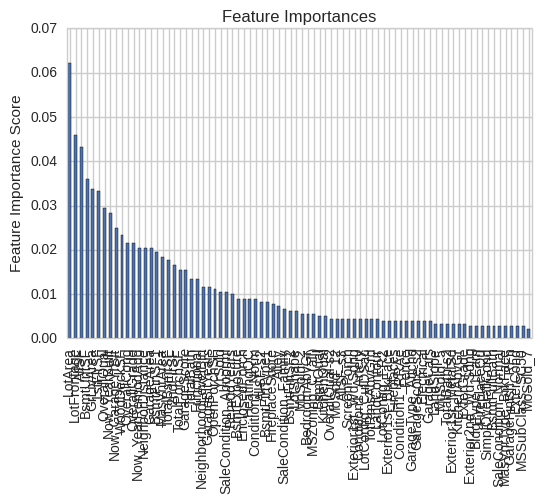

In [7]:
regressor = XGBRegressor(
                learning_rate =0.1,
                n_estimators=100,
                max_depth=5,
                min_child_weight=1,
                gamma=0,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_lambda = 0.1,
                reg_alpha = 0.1,
                scale_pos_weight=1,
                objective= 'reg:linear',
                seed=10)
regressor, feature_importances = model_fit(regressor, train_X, train_Y)

### 1. Choose a relatively high learning_rate,optimum n_estimators

### 2.Fix learning rate and number of estimators for tuning tree-based parameters